# Example 2: HA model with sticky prices and nominal bonds

In this notebook we 

- 1. solve a modified version of the one-asset HANK model from Auclert, Bardóczy, Rognlie, Straub (2021): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models" ([link to paper](https://www.bencebardoczy.com/publication/sequence-jacobian/sequence-jacobian.pdf)) For model details please see their paper

    Modifications:
         
         - All households work same amount of hours

         - Government Bonds are Nominal
    
2. Using the Jacobian from step 1 to compute the winding number to check determinacy following Hagedorn (2023) "Local Determinacy in Incomplete-Markets Models"

For more examples and information on the Local Determimnacy toolkit, please visit our [GitHub page](https://github.com/shade-econ/sequence-jacobian).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import local_determinacy as ld

from sequence_jacobian import simple, create_model  # functions
from sequence_jacobian import hetblocks, grids      # modules


## 2 The Model

We follow Auclert, Bardóczy, Rognlie, Straub (2021) and define

- Inputs for the heterogeneous household block 

- Other model (non-household) parts (steady state)

- Compute and Calibrate the Steady state

- Other model (non-household) parts (transition)

### 2.1 Hetinputs

We use the hetBlock`hh_sim` (standard incomplete markets model) from the SSJ toolkit located in `sequence_jacobian/hetblocks`.


In [2]:
hh = hetblocks.hh_sim.hh

def make_grids(rho_e, sd_e, n_e, min_a, max_a, n_a):
            e_grid, pi_e , Pi = grids.markov_rouwenhorst(rho_e, sd_e, n_e)
            a_grid = grids.asset_grid(min_a, max_a, n_a)
            return e_grid, pi_e, Pi, a_grid

def income(w, Tax, Y, pi_e, e_grid):
            tax_rule,  Y_rule = e_grid, e_grid
            yy = Y / np.sum(pi_e * Y_rule) * Y_rule
            tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
            #tax = Tax  
            y = w * yy - tax
            return y

hh1 = hh.add_hetinputs([make_grids, income])


### 2.2 Model Blocks 

We substitute lagged values to simplify the comuputation of the winding number.
Lagged Inflation P(-1) -> PL

$\underline{\text{Monetary policy rule}}$ for nominal interest rate $i_{t+1}$
$$
\frac{1+i_{t+1}}{1+r^*} = 1 +\phi  \frac{P(-1)-P_{ss}}{P_{ss}} = 1 +\phi  \frac{PL-P_{ss}}{P_{ss}},
$$
where $PL$ is the lagged price level, $P_{ss}$ is the steady-state price level and $r^*$ is the steady-state interest rate.



$\underline{\text{Fiscal policy rule}}$ for nominal debt 
$$
\frac{B_{t+1}}{B_{ss}} = 1+ \phi^B \frac{P(-1)-P_{ss}}{P_{ss}}   = 1 +\phi^B  \frac{PL-P_{ss}}{P_{ss}},
$$

In [3]:
@simple
def monetary(PL, rstar, rscale, phi,Pss):
            rN = (1 + rstar + rscale* phi * (PL-Pss)/Pss) -1 
            return rN

@simple
def monetaryReal(pi, Realshock, rN,  B, Y, w, F):
        r = (1 + rN) / (1 + pi) - 1 + Realshock + (Y*(1-w)-F)/B
        return r


@simple
def fiscal(rN, B, PL):
        Tax = (1+rN) * B/PL(+1) - B(+1)/PL(+1) 
        return Tax

@simple
def debt(PL, phiB,  Pss, Bss):
        B = Bss*(1+phiB * (PL-Pss)/Pss) 
        return B

@simple
def inflation(PL):
        pi =  PL(+1)/PL-1
        return pi


@simple
def nkpc_ss(Y, mu, vphi, frisch, eis, Yss):
        F = (1-1/mu)*Yss
        LL = Y
        Cons = Y - F 
        uc = Cons ** (-1 / eis)
        w = (vphi * LL ** (1 + 1 / frisch))/(uc)
        return w, F

@simple 
def mkt_clearing_A(A, B,PL, Bss):
        asset_mkt = (A - B(+1)/PL(+1))/Bss
        bonds = B/PL/Bss
        return asset_mkt, bonds

@simple 
def mkt_clearing_L(mu, w):
        labor_mkt = w - (1/mu)
        return  labor_mkt

### 2.3 Steady State and Calibration



In [4]:
blocks_ss = [hh1,monetary, monetaryReal, fiscal, debt, inflation,  mkt_clearing_A,  mkt_clearing_L, nkpc_ss]

hank_ss = create_model(blocks_ss, name="One-Asset Simple HANK SS")


calibration = {'eis': 1.0, 'rho_e': 0.9878, 'frisch': 0.5, 'sd_e': 0.7, 'n_e': 13,
               'min_a': 0.0, 'max_a': 1000, 'n_a': 200, 'PL': 1.0, 'Pss': 1.0, 'pi': 0.0, 'Bss': 4,  'Y': 1,  'Yss': 1,
               'mu': 1.1, 'kappa': 0.03, 'rN': 0.0125, 'rstar': 0.0125, 'rscale': 1.0125 , 'Realshock': 0.0 , 'phi': 0.0, 'phiB': 0.0, 'B': 4}

phistart = calibration['mu'] ** (1/calibration['eis']-1)
       
unknowns_ss = {'beta': 0.976, 'vphi': phistart}   
        
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")


### 2.4 Transition

The Phillips curve has to be added for transitions since prices are rigid.  All steady-state blocks are valid in transition. The New Keynesian Phillips curve is solved for output $Y$ as a function of inflation, so that the full model can be written as a function of inflation.

In [5]:
@simple
def nkpc(pi, beta, kappa):            
            Y = ss0["Y"] * (1+ (1+ss0["pi"] )*( (1 + pi).apply(np.log) - beta*(1 + pi(+1)).apply(np.log) )/kappa) 
            return Y

blocks = [hh1,monetary, monetaryReal, fiscal, debt, inflation, mkt_clearing_A, nkpc_ss, nkpc]
hank = create_model(blocks, name="One-Asset Nominal HANK")

ss = hank.steady_state(ss0)


### 3 Obtain Jacobian and Compute Winding Number 


-  Linearizing the asset market clearing condition, $A(P_{t-1},P_t, P_{t+1}, \ldots, P_{t+k}, \ldots) - B = 0$ with respect to  $x_{t+k} = P_{t+k-1}$ delivers infinite number of leads. There are no lags since we use $PL = P(-1)$.
			$$
		\sum_{k=0}^{\infty} A_k E_t x_{t+k} = 0,  
			$$	

-  The SSJ package delivers the derivatives of the asset market clearing condition, $A(P_{t-1}, P_t, P_{t+1}, \ldots, P_{t+k}, \ldots) - B = 0$,
			$$
		A_k = \frac{\partial (A(\ldots) - B)}{\partial x_{t+k}} =  \frac{\partial (A(\ldots) - B)}{\partial \pi_{t-1+k}}, \text{\hspace{0.2cm} for \hspace{0.1cm}} k=0,1,2,\ldots
			$$	
	where $x_{t+k} = P_{t+k-1} \hspace{0.1cm}$ for $ k=0,1,2,\ldots$
-  Onatski (06) defines the complex function
			$$
			{\color{red} \Theta(\lambda)} = det \sum_{k=0}^{\infty} A_k e^{-i k \lambda},
			$$
- ${\color{red} \text{Winding number}}$ is defined as  the number of times the graph of $\Theta(\lambda)$ rotates around zero counter-clockwise when $\lambda$ goes form $0$ to $2 \pi$.

- Ontaski (2006) shows
	
	- ${\color{red} \text{Determinacy}}$  (=unique bounded solution) if the ${\color{green} \text{winding number }}$  of $\Theta(\lambda)$ is equal to ${\color{green} \text{zero}}$.

	- ${\color{red} \text{ Multiple Solutions}}$    if winding number is ${\color{green} \text{less than zero}}$.

	- ${\color{red} \text{ No Solution}}$ if winding number is ${\color{green} \text{larger than zero}}$.

		 
		 

### 4 Algorithm: Specification Details

- The ${\color{blue} \text{unknown}}$  variable is lagged price level: ${\color{red} \text{PL}}$ 

- The price level is ${\color{blue} \text{not predetermined}}$:   ${\color{red} \text{predetermined=[0]}}$ 

- The price level is a ${\color{blue} \text{lagged}}$ variable (policy rule): ${\color{red} \text{lags=[1]}}$ 

- The equilibrium condition (${\color{blue} \text{targets}}$) is the asset market clearing condition: ${\color{red} \text{asset\_mkt}}$ 

Winding number: 0
The economy is DETERMINATE


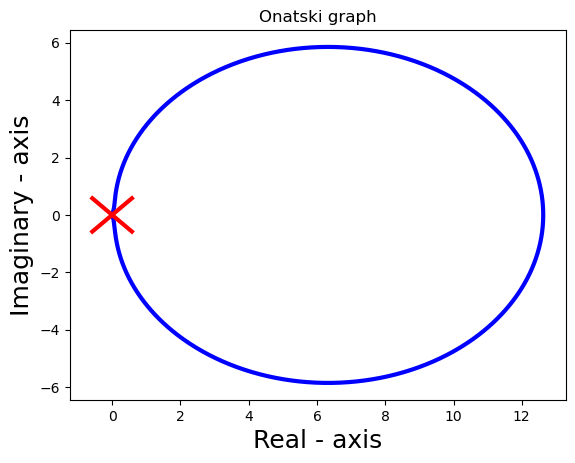

In [6]:
T = 300

exogenous = ['Realshock']
unknowns = ['PL']
targets = ['asset_mkt','bonds']

H_U = hank.jacobian(ss, unknowns, targets, T=T)
H_Z = hank.jacobian(ss, exogenous, targets, T=T)


targets = ['asset_mkt']

onatski, dU = ld.onatski(targets = targets, endogenous = unknowns,  predetermined=[0], lags=[1] , T =T, ss0=ss0, H_U = H_U,  exogenous = 'Realshock', H_Z = H_Z)


windingNumber = ld.onatskiWindingNumber(onatski)
print(ld.checkSolutions(windingNumber))

ld.plot(onatski)
